# The Acrobot

*We recommend you look at the [Introduction to Crocoddyl](introduction_to_crocoddyl.ipynb) example before this one.*

In the example, we model the acrobot control problem using Crocoddyl. An acrobot is a two joint planar robot with only one actuator. It is a canonnical example of an underactuated system and so presents an interesting control problem.

We demonstrate how to:

1. Load a model from an urdf.
1. Define an actuation mapping for the system.
1. Construct and solve the control problem.

## Loading the model
A standalone double pendulum robot urdf is provided in the [example-robot-data](https://github.com/Gepetto/example-robot-data) repository, this comes bundled with Crocoddyl. Let's load the model and inspect its properties.

In [10]:
import os
import sys
import numpy as np
import pathlib
import crocoddyl
import pinocchio
import time

# Get the path to the urdf
from example_robot_data.path import EXAMPLE_ROBOT_DATA_MODEL_DIR

urdf_model_path = pathlib.Path(
    "double_pendulum_description", "urdf", "double_pendulum_simple.urdf"
)
urdf_model_path = os.path.join(EXAMPLE_ROBOT_DATA_MODEL_DIR, urdf_model_path)

# Now load the model (using pinocchio)
robot = pinocchio.robot_wrapper.RobotWrapper.BuildFromURDF(str(urdf_model_path))

# The model loaded from urdf (via pinicchio)
print(robot.model)
 # reduced artificially the torque limits

# Create a multibody state from the pinocchio model.
state = crocoddyl.StateMultibody(robot.model)

Nb joints = 3 (nq=2,nv=2)
  Joint 0 universe: parent=0
  Joint 1 joint1: parent=0
  Joint 2 joint2: parent=1



`pinocchio` comes with some handy wrappers that load a robot along with vizual and collision models. These are all defined via that urdf. `robot.model` is the model is a model of the DAEs (Differential Algebraic Equations).

You will notice that the there are two joint configurations `nq` and velocities `nv`.

## Actuation Mapping
In order to create an underactuated double pendulum, the acrobot, we will create mapping between control inputs and joint torques. This is done by inheriting from `ActuationModelAbstract`. See also `ActuationModelFloatingBase` and `ActuationModelFull` for other options.

In [2]:
# Define the control signal to actuated joint mapping
class AcrobotActuationModel(crocoddyl.ActuationModelAbstract):
    def __init__(self, state):
        nu = 2  # Control dimension
        crocoddyl.ActuationModelAbstract.__init__(self, state, nu=nu)

    def calc(self, data, x, u):
        assert len(data.tau) == 2
        # Map the control dimensions to the joint torque
        data.tau[0] = u[0]
        data.tau[1] = u[1]

    def calcDiff(self, data, x, u):
        # Specify the actuation jacobian
        data.dtau_du[0,0] = 1
        data.dtau_du[0,1] = 0
        data.dtau_du[1,0] = 0
        data.dtau_du[1,1] = 1

# Also see ActuationModelFloatingBase and ActuationModelFull
actuationModel = AcrobotActuationModel(state)

## Constructing the Problem

Before we solve the control problem, we need to construct the cost models and action models.

In [3]:
dt = 0.5e-3  # Time step
T = 2000  # Number of knots

# Cost models
runningCostModel = crocoddyl.CostModelSum(state, nu=actuationModel.nu)
terminalCostModel = crocoddyl.CostModelSum(state, nu=actuationModel.nu)

# Add a cost for the configuration positions and velocities
xref = np.array([0, 0, 0, 0])  # Desired state
stateResidual = crocoddyl.ResidualModelState(state, xref=xref, nu=actuationModel.nu)
stateCostModel = crocoddyl.CostModelResidual(state, stateResidual)
runningCostModel.addCost("state_cost", cost=stateCostModel, weight=1)   #1e-5/dt
terminalCostModel.addCost("state_cost", cost=stateCostModel, weight=100)    #1000   

# Add a cost on control
controlResidual = crocoddyl.ResidualModelControl(state, nu=actuationModel.nu)
bounds = crocoddyl.ActivationBounds(np.array([-2.0,-2.0]),np.array([2.0,2.0]))
activation = crocoddyl.ActivationModelQuadraticBarrier(bounds)
controlCost = crocoddyl.CostModelResidual(
    state, activation=activation, residual=controlResidual
)
runningCostModel.addCost("control_cost", cost=controlCost, weight=1e-1 / dt)   #1e-1

# Create the action models for the state
runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuationModel, runningCostModel
    ),
    dt,
)
terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(
        state, actuationModel, terminalCostModel
    ),
    0.0,
)

Now we define the control problem.

In [4]:

# Define a shooting problem
q0 = np.zeros((state.nq,))  # Inital joint configurations
q0[0] = np.pi/2 # Down
v0 = np.zeros((state.nv,))  # Initial joint velocities
x0 = np.concatenate((q0, v0))  # Inital robot state
problem = crocoddyl.ShootingProblem(x0, [runningModel] * T, terminalModel)

Let's test the system with a rollout.

In [5]:
# # Test the problem with a rollout
# us = [0.01 * np.ones((2,))] * T
# xs = problem.rollout(us)

# # Handy to blat up the state and control trajectories
# crocoddyl.plotOCSolution(xs, us, show=False, figIndex=99, figTitle="Test rollout")

# # Put a grid on the plots
# import matplotlib.pyplot as plt

# fig = plt.gcf()
# axs = fig.axes
# for ax in axs:
#     ax.grid()

Now we can solve the optimal control problem.

In [6]:
# Now stabilize the acrobot using FDDP
solver = crocoddyl.SolverFDDP(problem)

# Solve
callbacks = []
callbacks.append(crocoddyl.CallbackLogger())
callbacks.append(crocoddyl.CallbackVerbose())
solver.setCallbacks(callbacks)

start_time= time.time()
solver.solve([], [], 300, False, 1e-5)
end_time  = time.time()
print((end_time-start_time)*1000,"ms")

iter     cost         stop         grad         xreg         ureg       step    ||ffeas||    ||gfeas||    ||hfeas|| 
   0  1.53426e-01  1.65379e+00  -3.30758e+00  1.00000e-05  1.00000e-05  0.2500  1.57080e+00  0.00000e+00  0.00000e+00
   1  9.38309e-01  1.48448e+00  -1.75739e+00  1.00000e-05  1.00000e-05  0.2500  1.17810e+00  0.00000e+00  0.00000e+00
   2  9.48771e-01  6.94184e-01  2.05821e-01  1.00000e-05  1.00000e-05  0.1250  8.83573e-01  0.00000e+00  0.00000e+00
   3  9.67432e-01  6.82377e-01  2.56073e-01  1.00000e-05  1.00000e-05  0.1250  7.73126e-01  0.00000e+00  0.00000e+00
   4  1.01871e+00  6.62321e-01  2.66679e-01  1.00000e-05  1.00000e-05  0.1250  6.76486e-01  0.00000e+00  0.00000e+00
   5  1.04868e+00  6.10436e-01  3.04684e-01  1.00000e-05  1.00000e-05  0.1250  5.91925e-01  0.00000e+00  0.00000e+00
   6  1.25167e+00  5.79690e-01  2.77385e-01  1.00000e-05  1.00000e-05  0.2500  5.17934e-01  0.00000e+00  0.00000e+00
   7  1.33016e+00  3.75666e-01  4.60363e-01  1.00000e-05  1.00

We can visualize the trajectory with `meshcat` or using `gepetto-gui` (you will need to install [gepetto-viewer]() and [gepetto-viewer-corba]() and start the process in a separate terminal.)

In [7]:
# Display using meshcat
#robot_display = crocoddyl.MeshcatDisplay(robot, -1, 1, False)
#display(robot_display.robot.viewer.jupyter_cell())
#robot_display.displayFromSolver(solver)

# Display using gepetto-gui
if False:
  robot_display = crocoddyl.GepettoDisplay(robot, floor=False)
  robot_display.displayFromSolver(solver)

We can plot the trajectory and the solver's convergence properties.

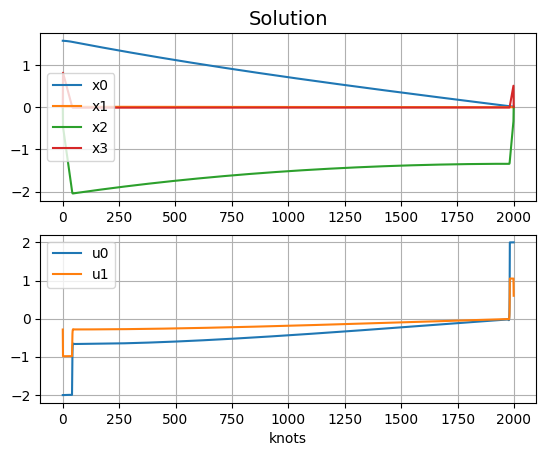

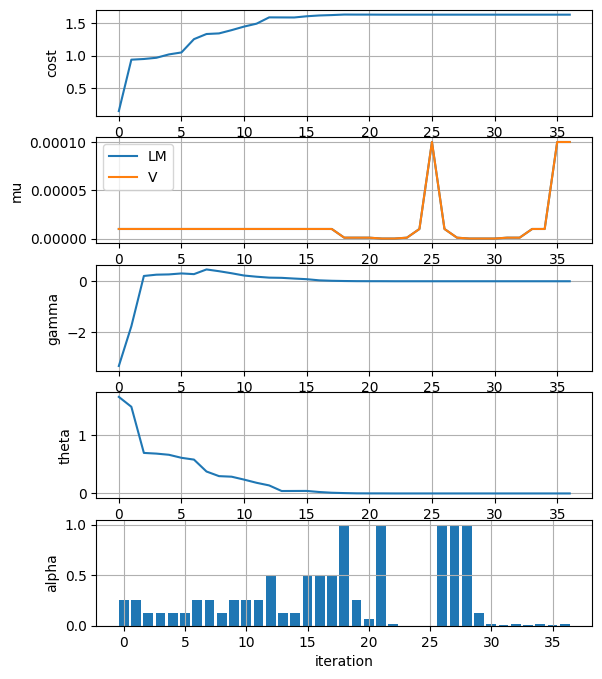

In [8]:
# Plotting the solution and the DDP convergence
log = solver.getCallbacks()[0]

import matplotlib.pyplot as plt

crocoddyl.plotOCSolution(
    xs=log.xs, us=log.us, show=False, figIndex=1, figTitle="Solution"
)
fig = plt.gcf()
axs = fig.axes
for ax in axs:
    ax.grid(True)

crocoddyl.plotConvergence(
    log.costs,
    log.u_regs,
    log.x_regs,
    log.grads,
    log.stops,
    log.steps,
    show=False,
    figIndex=2,
)
fig = plt.gcf()
axs = fig.axes
for ax in axs:
    ax.grid(True)

plt.show()